# Definition of used classes

In [20]:
import os
import math
from datetime import datetime
from abc import ABC, abstractmethod
from typing import Any, Dict, List, Tuple
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow

from IPython.display import clear_output
from IPython.display import Video

from pygame import Vector2 as Vec2
from pygame import Color as Color

# Constants
FPS: int = 30
SCREEN_SIZE: Vec2 = Vec2(640, 440)
PITCH_SIZE: Vec2 = Vec2(600, 400)
PITCH_POS: Vec2 = (SCREEN_SIZE - PITCH_SIZE) / 2
POST_TOP_Y: float = PITCH_POS.y + PITCH_SIZE.y * 6 / 16
POST_BOT_Y: float = PITCH_POS.y + PITCH_SIZE.y * 10 / 16
LINE_WIDTH: int = 2

# Color palette
COLOR_WHITE: Color = Color(255, 255, 255)
COLOR_BLACK: Color = Color(0, 0, 0)
COLOR_LINE: Color = Color(174, 202, 137)
COLOR_PITCH: Color = Color(113, 152, 63)
COLOR_BACKGROUND: Color = Color(91, 143, 164)


class Drawable(ABC):
    @abstractmethod
    def draw(self, img):
        raise NotImplementedError()


class CirclePhysical(ABC):
    COUNT: int = 0

    def __init__(self, radius: float, mass: float, pos: Vec2, hooked: bool = False):
        self.id: int = CirclePhysical.COUNT
        CirclePhysical.COUNT += 1

        self.radius: float = radius
        self.mass: float = mass
        self.friction: float = 0.7 * mass
        self.v_max = 12 / math.pow(mass, 2 / 3)
        self.pos: Vec2 = pos
        self.vel: Vec2 = Vec2(0, 0)
        self.hooked: bool = hooked

    def setPos(self, pos: Vec2):
        self.pos = pos

    def setVel(self, vel: Vec2):
        self.vel = vel * self.mass

    def addVel(self, vel: Vec2):
        self.vel += vel

    def update(self, dt: float):
        self.pos += self.vel * dt

        self.vel += -self.vel * self.friction * dt
        self.pos += self.vel * dt

        if self.vel.magnitude() > self.v_max:
            self.vel = self.vel.normalize() * self.v_max

    @staticmethod
    def sphereCollisionVelocities(
            v1: Vec2, v2: Vec2,
            m1: float, m2: float,
            x1: Vec2, x2: Vec2) -> Tuple[Vec2, Vec2]:
        # Calculate new velocities after collision
        mass: float = 2 * m1 / (m1 + m2)
        v1_new: Vec2 = v1 - (mass * (v1 - v2).dot(x1 - x2) / pow((x1 - x2).length(), 2)) * (x1 - x2)
        v2_new: Vec2 = v2 - (mass * (v2 - v1).dot(x2 - x1) / pow((x2 - x1).length(), 2)) * (x2 - x1)
        return v1_new, v2_new

    def collide(self, other: 'CirclePhysical'):
        dist = self.pos.distance_to(other.pos)
        if dist < self.radius + other.radius:
            if dist == 0:
                self.pos += -self.vel.normalize() * 0.01

            self.vel, other.vel = CirclePhysical.sphereCollisionVelocities(
                self.vel, other.vel, self.mass, other.mass, self.pos, other.pos)

            if not self.hooked:
                self.pos += (self.pos - other.pos).normalize() * (self.radius + other.radius - dist) / 2
            else:
                self.vel = Vec2(0, 0)

            if not other.hooked:
                other.pos += (other.pos - self.pos).normalize() * (self.radius + other.radius - dist) / 2
            else:
                other.vel = Vec2(0, 0)


class Ball(CirclePhysical, Drawable):
    COLOR: Color = Color(255, 255, 255)
    MASS: float = 0.2
    RADIUS: float = 7

    def __init__(self, pos: Vec2 = Vec2(SCREEN_SIZE.x / 2, SCREEN_SIZE.y / 2)):
        super().__init__(
            radius=self.RADIUS, mass=self.MASS, pos=pos)

    def draw(self, img):
        cv2.circle(img, (int(self.pos.x), int(self.pos.y)), self.radius, self.COLOR, -1)


class Player(CirclePhysical, Drawable):
    MASS: float = 0.5
    RADIUS: float = 10

    def __init__(self, pos: Vec2, color: Color):
        super().__init__(
            radius=self.RADIUS, mass=self.MASS, pos=pos)

        self.color: Color = color

    def draw(self, img):
        cv2.circle(img, (int(self.pos.x), int(self.pos.y)), self.radius, self.color, -1)


class Post(CirclePhysical, Drawable):
    MASS: float = 1
    RADIUS: float = 6

    def __init__(self, pos: Vec2, color: Color):
        super().__init__(
            radius=self.RADIUS, mass=self.MASS, pos=pos, hooked=True)

        self.color: Color = color

    def draw(self, img):
        cv2.circle(img, (int(self.pos.x), int(self.pos.y)), self.radius, self.color, -1)


class Goal(Drawable):
    def __init__(self, dir: int, linePos: float, postTopY: float, postBotY: float, color: Color):
        self.dir: int = dir
        self.linePos: float = linePos
        self.yTop: float = postTopY
        self.yBot: float = postBotY
        self.color: Color = color

        self.postTop: Post = Post(Vec2(linePos, postTopY), color)
        self.postBot: Post = Post(Vec2(linePos, postBotY), color)

    def draw(self, img):
        cv2.line(img, (int(self.linePos), int(self.yTop)), (int(self.linePos), int(self.yBot)), self.color, LINE_WIDTH)
        self.postTop.draw(img)
        self.postBot.draw(img)


class Team(Drawable):
    def __init__(self, dir: int, color: Color):
        self.color: Color = color

        # Dir is 1 or -1
        # 1 is attacking from left to right
        # -1 is attacking from right to left
        self.dir: int = dir

        # Normalized dir is 0 or 1
        # 0 is attacking from left to right
        # 1 is attacking from right to left
        self.normalizedDir: int = -(dir - 1) / 2

        # Goal line for dir 1 is pitchPos.x
        # Goal line for dir -1 is pitchPos.x + pitchSize.x
        goalLineX: float = PITCH_POS.x + PITCH_SIZE.x * self.normalizedDir

        self.goal: Goal = Goal(dir, goalLineX, POST_TOP_Y, POST_BOT_Y, color)
        self.player: Player = Player(Vec2(goalLineX, SCREEN_SIZE.y / 2), color)

        self.score: int = 0

    def draw(self, img):
        self.goal.draw(img)
        self.player.draw(img)

    def reset(self):
        self.score = 0
        self.player.setPos(Vec2(self.goal.linePos + self.dir * PITCH_SIZE.x / 4, SCREEN_SIZE.y / 2 + self.dir * SCREEN_SIZE.y / 6))
        self.player.setVel(Vec2(0, 0))

    def applyAction(self, action: Vec2):
        # Convert action to direction and invert it in relation to team dir
        if action.length() != 0:
            vel: Vec2 = action.normalize() * self.dir

            # Apply velocity to player
            self.player.addVel(vel)


class Pitch(Drawable):
    def __init__(self):
        self.team1: Team = Team(1, Color(255, 0, 0))
        self.team2: Team = Team(-1, Color(0, 0, 255))

    def draw(self, img):
        # Draw pitch as a solid color filled rectangle with a line border
        cv2.rectangle(img, (int(PITCH_POS.x), int(PITCH_POS.y)),
                      (int(PITCH_POS.x + PITCH_SIZE.x), int(PITCH_POS.y + PITCH_SIZE.y)), COLOR_PITCH, -1)
        cv2.rectangle(img, (int(PITCH_POS.x), int(PITCH_POS.y)),
                      (int(PITCH_POS.x + PITCH_SIZE.x), int(PITCH_POS.y + PITCH_SIZE.y)), COLOR_LINE, LINE_WIDTH)

        # Draw center line
        cv2.line(img, (int(PITCH_POS.x + PITCH_SIZE.x / 2), int(PITCH_POS.y)),
                 (int(PITCH_POS.x + PITCH_SIZE.x / 2), int(PITCH_POS.y + PITCH_SIZE.y)), COLOR_LINE, LINE_WIDTH)
        cv2.circle(img, (int(PITCH_POS.x + PITCH_SIZE.x / 2), int(PITCH_POS.y + PITCH_SIZE.y / 2)),
                   int(PITCH_SIZE.y / 6), COLOR_LINE, LINE_WIDTH)

        # Draw goals
        self.team1.draw(img)
        self.team2.draw(img)

    def pitchCollision(self, sphere: CirclePhysical, dt: float) -> int:
        # Check sphere's collision with pitch
        # Return 0 if nothing happens
        # Return 1 if team sphere is in goal of team 1
        # Return 2 if team sphere is in goal of team 2

        # Check if the sphere collides with the pitch's top or bottom
        if (sphere.pos.y - sphere.radius < PITCH_POS.y or
                sphere.pos.y + sphere.radius > PITCH_POS.y + PITCH_SIZE.y):
            sphere.pos.y += -sphere.vel.y * dt
            sphere.vel.y *= -1

        # Check if the sphere collides with the goal
        if (sphere.pos.y > POST_TOP_Y and sphere.pos.y < POST_BOT_Y) and isinstance(sphere, Ball):
            # Check if the sphere collides with the goal of team 1
            if (sphere.pos.x + sphere.radius < self.team1.goal.linePos):
                return 1

            # Check if the sphere collides with the goal of team 2
            if (sphere.pos.x - sphere.radius > self.team2.goal.linePos):
                return 2

            return 0

        # Check if the sphere collides with the pitch's left or right
        if (sphere.pos.x - sphere.radius < PITCH_POS.x or
                sphere.pos.x + sphere.radius > PITCH_POS.x + PITCH_SIZE.x):
            sphere.pos.x += -sphere.vel.x * dt
            sphere.vel.x *= -1

        return 0


class ReplayBuffer():
    def __init__(self):
        self.buffer: List[Tuple(Vec2, Vec2, Vec2)] = []

    def snapshot(self, ball: Ball, team1: Team, team2: Team):
        self.buffer.append((ball.pos.copy(), team1.player.pos.copy(), team2.player.pos.copy()))

    def reset(self):
        self.buffer = []


class Haxball():
    def __init__(self):
        self.ball: Ball = Ball()
        self.pitch: Pitch = Pitch()
        self.player1: Player = self.pitch.team1.player
        self.player2: Player = self.pitch.team2.player

        self.circlePhysicals: List[CirclePhysical] = [
            self.ball, self.player1, self.player2,
            self.pitch.team1.goal.postTop, self.pitch.team1.goal.postBot,
            self.pitch.team2.goal.postTop, self.pitch.team2.goal.postBot
        ]

        self.paused: bool
        self.lastAction1: Vec2 = Vec2(0, 0)
        self.lastAction2: Vec2 = Vec2(0, 0)

        self.replayBuffer: ReplayBuffer = ReplayBuffer()

        self.reset()

    def reset(self):
        self.paused = False
        self.lastAction1 = Vec2(0, 0)
        self.lastAction2 = Vec2(0, 0)

        # Reset ball
        self.ball.setPos(Vec2(SCREEN_SIZE.x / 2, SCREEN_SIZE.y / 2))
        self.ball.setVel(Vec2(0, 0))

        # Reset teams
        self.pitch.team1.reset()
        self.pitch.team2.reset()

        # Save first snapshot to replay buffer
        self.replayBuffer.reset()
        self.replayBuffer.snapshot(self.ball, self.pitch.team1, self.pitch.team2)

    @staticmethod
    def getRelativePos(pos: Vec2, dir: int) -> Vec2:
        # Return player position normalized to the given dir
        # (0, PITCH_SIZE.y / 2) is the center of own goal line

        normalizedDir = -(dir - 1) / 2

        return (pos - SCREEN_SIZE * normalizedDir) * dir

    @staticmethod
    def getRelativeVel(vel: Vec2, dir) -> Vec2:
        # Return player velocity normalized to the given dir

        return vel * dir

    def info(self):
        info = dict()
        info["pitch_size"] = (int(PITCH_SIZE.x), int(PITCH_SIZE.y))
        info["pitch_pos"] = (int(PITCH_POS.x), int(PITCH_POS.y))
        info["screen_size"] = (int(SCREEN_SIZE.x), int(SCREEN_SIZE.y))
        info["player_radius"] = Player.RADIUS
        info["ball_radius"] = Ball.RADIUS
        info["post_radius"] = Post.RADIUS
        info["goal_width"] = POST_BOT_Y - POST_TOP_Y
        info["own_postTop_pos"] = self.getRelativePos(self.pitch.team1.goal.postTop.pos, 1)
        info["own_postBot_pos"] = self.getRelativePos(self.pitch.team1.goal.postBot.pos, 1)
        info["opp_postTop_pos"] = self.getRelativePos(self.pitch.team2.goal.postTop.pos, 1)
        info["opp_postBot_pos"] = self.getRelativePos(self.pitch.team2.goal.postBot.pos, 1)
        info["state_space"] = 12
        info["action_space"] = 2
        return info

    def state(self):
        return self.getState(1), self.getState(2), self.paused

    def render(self):
        img = np.zeros((int(SCREEN_SIZE.y), int(SCREEN_SIZE.x), 3), np.uint8)

        cv2.rectangle(img, (0, 0), (int(SCREEN_SIZE.x), int(SCREEN_SIZE.y)), COLOR_BACKGROUND, -1)

        self.pitch.draw(img)
        self.ball.draw(img)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        return img

    def showReplay(self, custom_string=""):
        video_path = f"tmp_{custom_string}_{datetime.now().strftime("%d-%m-%y--%H-%M-%S")}.mp4"

        video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*"mp4v"), FPS, (self.render().shape[1::-1]))

        # Create video for whole replay buffer
        for snapshot in self.replayBuffer.buffer:
            # print(snapshot)
            self.ball.pos = snapshot[0]
            self.pitch.team1.player.pos = snapshot[1]
            self.pitch.team2.player.pos = snapshot[2]

            video.write(self.render())

        # video.release()
        # fileToDisplay = "video.mp4"
        # os.system(f"ffmpeg -loglevel level+fatal -y -i {video_path} -vcodec libx264 -x264opts keyint=123:min-keyint=120 -an {fileToDisplay}")
        # display(Video(video_path, embed=True))

    def getState(self, team: int):
        dir: int
        reward: int
        lastAction: Vec2
        player: Player
        opponent: Player

        if team == 1:
            dir = 1
            reward = self.pitch.team1.score
            lastAction = self.lastAction1
            player = self.player1
            opponent = self.player2
        elif team == 2:
            dir = -1
            reward = self.pitch.team2.score
            lastAction = self.lastAction2
            player = self.player2
            opponent = self.player1
        else:
            raise Exception("Invalid team")

        ballPos: Vec2 = self.getRelativePos(self.ball.pos, dir)
        ballVel: Vec2 = self.getRelativeVel(self.ball.vel, dir)
        playerPos: Vec2 = self.getRelativePos(player.pos, dir)
        playerVel: Vec2 = self.getRelativeVel(player.vel, dir)
        opponentPos: Vec2 = self.getRelativePos(opponent.pos, dir)
        opponentVel: Vec2 = self.getRelativeVel(opponent.vel, dir)

        state: List[float] = [
            ballPos.x, ballPos.y, ballVel.x, ballVel.y,
            playerPos.x, playerPos.y, playerVel.x, playerVel.y,
            opponentPos.x, opponentPos.y, opponentVel.x, opponentVel.y
        ]

        return state, reward, lastAction

    def collide(self, sphere: CirclePhysical, dt: float) -> int:
        # Collide with other spheres
        for other in self.circlePhysicals:
            if other != sphere:
                sphere.collide(other)

        # Collide with pitch
        return self.pitch.pitchCollision(sphere, dt)

    def step(self, action1: Vec2, action2: Vec2):
        if self.paused:
            self.replayBuffer.snapshot(self.ball, self.pitch.team1, self.pitch.team2)
            return self.state()

        dt: float = 15 / FPS

        # Apply actions
        self.pitch.team1.applyAction(action1)
        self.pitch.team2.applyAction(action2)

        # Update players
        self.player1.update(dt)
        self.player2.update(dt)
        # Update ball
        self.ball.update(dt)

        # Check for collisions
        self.collide(self.player1, dt)
        self.collide(self.player2, dt)
        res: int = self.collide(self.ball, dt)

        # Save snapshot to replay buffer
        self.replayBuffer.snapshot(self.ball, self.pitch.team1, self.pitch.team2)

        self.lastAction1 = action1
        self.lastAction2 = action2

        # Check if a goal was scored
        if res == 1:
            print("GOAL! for team 2")
            self.pitch.team2.score += 1
            self.paused = True
        elif res == 2:
            self.pitch.team1.score += 1
            print("GOAL! for team 1")
            self.paused = True

        return self.state()


# The environment
The environment was defined in the Haxball class.<br>

### State
State is returned by function `step(action1, action2)` or `state()`.
State consists of 3 values: `state1, state2, done`:
* `state1` -- `Tuple(state, reward, lastAction)`:
  * `state` -- `Dict`: game state from the perspective of a player 1:
    * `ballPos` -- `Vec2`: position of the ball
    * `ballVel` -- `Vec2`: velocity of the ball
    * `playerPos` -- `Vec2`: position of the player
    * `playerVel` -- `Vec2`: velocity of the player
    * `opponentPos` -- `Vec2`: position of the opponent
    * `opponentVel` -- `Vec2`: velocity of the opponent
  * `reward` -- `int`: reward for the last action
  * `lastAction` -- `Vec2`: last action taken by the player
* `state2` -- same as `state1` but from the perspective of a player 2
* `done` -- `bool`: True if the game is over (goal was scored)


### Info
Function `info()` returns a dictionary containing information about the environment:
 * `pitch_size` -- size of the pitch
 * `pitch_pos` -- position of the top left corner of the screen
 * `screen_size` -- size of the whole screen (pitch + border)
 * `player_radius` -- radius of the player
 * `ball_radius` -- radius of the ball
 * `post_radius` -- radius of the post
 * `goal_width` -- width of the goal (y of the bottom post - y of the top post)

### Action
Action is continuous and is a `Vec2` type. It specifies the direction of the movement. It doesn't have to be normalized (magnitude doesn't affect the velocity).

Action is relative to the player's goal. `Vec(1, 0)` (forward movement along x-axis) for one player means going to the right side of the screen, but for another it means going to the left (from the viewer's perspective).

States are already properly reflected in relation to player's goal, so if you work on them, actions should work the some for both players - there is no difference which player you are using.

`Vec2` is a `pygame.Vector2` type. You can look up it's documentation online. It supports basic vector operations.


### Reset
`reset()` resets the environment: score, all positions and velocities and replay buffer.

### Replays
`showReplay()` displays video of a last game (since the last reset).

### Environment parameters
On top of the code "Constants" section can be found. They can be used to modify the environment.
You can change them to modify the environment:
* `FPS` - number of frames per second - affects the video, but also the simulation (changes number of simulation steps)
* `SCREEN_SIZE` - size of the screen - can't be smaller than pitch size - affects performance of video rendering
* `PITCH_SIZE` - size of the pitch - affects the domain of the problem
* `POST_TOP_Y/POST_BOT_Y` - width of the goal


In [5]:
env = Haxball()
info = env.info()
print(f"info: {info}\n")

state1, state2, done = env.state()
print(f"state1: {state1}\n")
print(f"state2: {state2}\n")
print(f"done:  {done}")


info: {'pitch_size': (600, 400), 'pitch_pos': (20, 20), 'screen_size': (640, 440), 'player_radius': 10, 'ball_radius': 7, 'post_radius': 6, 'goal_width': 100.0, 'own_postTop_pos': <Vector2(20, 170)>, 'own_postBot_pos': <Vector2(20, 270)>, 'opp_postTop_pos': <Vector2(620, 170)>, 'opp_postBot_pos': <Vector2(620, 270)>, 'state_space': 12, 'action_space': 2}

state1: ([320.0, 220.0, 0.0, 0.0, 170.0, 293.3333333333333, 0.0, 0.0, 470.0, 146.66666666666669, 0.0, 0.0], 0, <Vector2(0, 0)>)

state2: ([320.0, 220.0, -0.0, -0.0, 170.0, 293.3333333333333, -0.0, -0.0, 470.0, 146.66666666666669, -0.0, -0.0], 0, <Vector2(0, 0)>)

done:  False


## Sample game simulation

Below you can see a sample game simulation. Half of the moves are random and half are forward (notice that forward movement is different direction for each player!).

Frames count is specified in `frames` variable. You can change it to see longer games. Length of the game (in seconds) is `frames / FPS`.

After the game, replay is generated.

In [6]:
import random

def randomVector():
    # Return a random vector from -1 to 1
    return Vec2(random.random() * 2 - 1, random.random() * 2 - 1)

env.reset()

# Play a random game
frames: int = 720

for i in range(frames):
    if random.random() < 0.5:
        # Move randomly
        state1, state2, done = env.step(randomVector(), randomVector())
    else:
        # Move forward
        state1, state2, done = env.step(Vec2(15, 0), Vec2(1, 0))

env.showReplay()

## Movement towards the ball

Below you can see a different game simulation. In this game, players are always moving towards the ball. Notice how the direction towards the ball is calculated from state info.

In [7]:
import random

env = Haxball()

# Play a random game
frames: int = 1800

for i in range(frames):
    # Move agent towards the ball
    player1State, reward, lastAction = env.getState(1)
    player2State, reward, lastAction = env.getState(2)

    ball1Pos: Vec2 = Vec2(player1State[0], player1State[1])
    player1Pos: Vec2 = Vec2(player1State[4], player1State[5])

    ball2Pos: Vec2 = Vec2(player2State[0], player2State[1])
    player2Pos: Vec2 = Vec2(player2State[4], player2State[5])

    diff1: Vec2 = (ball1Pos - player1Pos).normalize()
    diff2: Vec2 = (ball2Pos - player2Pos).normalize()

    state1, state2, done = env.step(diff1, diff2)


env.showReplay()

GOAL! for team 2


# Zadanie wykładowe 2
Stwórz wirtualnego gracza piłki nożnej sterowanego z wykorzystaniem sieci neuronowej. Wykorzystaj jeden z algortmów z wykładu siódmego: DQN, Double DQN lub Dueling DQN.

# Zadania do wykonania
* Opracuj sieć neuronową wyznaczającą wartość Q.
* Zaimplementuj algorytm uczenia sieci neuronowej.
* Naucz piłkarza dryblowania, czyli prowadzenia piłki do wskazanego punktu.
* Naucz piłkarza omijania przeciwnika i prowadzenia piłki do bramki.
* Przeprowadź gry między opracowanymi graczami.



In [29]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from pygame.math import Vector2 as Vec2


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [30]:
cos_22dot5 = 1/2*((2+(2**(1/2)))**(1/2))
second_side = 1-1/4*(2+(2**(1/2)))
possible_moves = [Vec2(0,0)
                 , Vec2(1, 0), Vec2(0, 1), Vec2(-1, 0), Vec2(0, -1)
                 , Vec2(1, 1), Vec2(-1, -1), Vec2(-1, 1), Vec2(1, -1)
                 , Vec2(cos_22dot5, second_side), Vec2(-cos_22dot5, -second_side), Vec2(-cos_22dot5, second_side), Vec2(cos_22dot5, -second_side)
                 , Vec2(second_side, cos_22dot5), Vec2(-second_side, -cos_22dot5), Vec2(-second_side, cos_22dot5), Vec2(second_side, -cos_22dot5)]


In [31]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(device)


cuda


In [32]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [33]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [34]:
class TrainingParams:
    def __init__(self, batch_size = 128, gamma = 0.99, epsilon_start = 0.9, epsilon_end = 0.02, epsilon_decay = 10000, learning_rate = 1e-4
                 , update_rate = 0.005, replay_memory_size = 1e4):
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.update_rate = update_rate
        self.replay_memory_size = replay_memory_size

class Agent:
    def __init__(self, n_observations, n_actions, training_params, reward_system):
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.training_params = training_params

        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(policy_net.state_dict())
        self.optimizer = optim.AdamW(policy_net.parameters(), lr=self.training_params.learning_rate, amsgrad=True)
        self.memory = ReplayMemory(self.training_params.replay_memory_size)
        self.steps_done = 0


    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.training_params.EPS_END + (self.training_params.epsilon_start - self.training_params.epsilon_end) * \
            math.exp(-1. * self.steps_done / self.training_params.epsilon_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([random.choice(possible_moves)], device=device, dtype=torch.double)

    
    def optimize_model(self):
        if len(self.memory) < self.training_params.batch_size:
            return
        transitions = self.memory.sample(self.training_params.batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None]).to(device)
        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.training_params.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)).to(device)
    
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        optimizer.step()


    def save(self, filename):
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'memory': self.memory,
            'steps_done': self.steps_done
        })
        print(f"saved to: {filename}")
        
    def load(self, filename):
        data = torch.load(filename)
        self.policy_net.load_state_dict(data['policy_net'])
        self.policy_net.load_state_dict(data['target_net'])
        self.policy_net.load_state_dict(data['optimizer'])
        self.memory = data['memory']
        self.steps_done = data['steps_done']


In [17]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())              


Complete


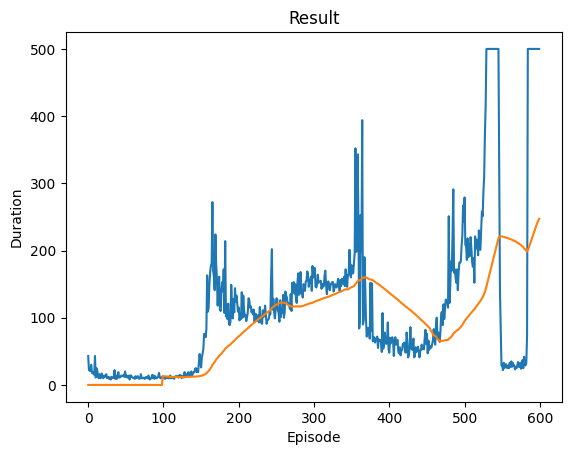

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            if i_episode % 10 == 0:
                plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


In [25]:
env = Haxball()
n_actions = len(possible_moves)
# Get the number of state observations
(state, _), _ = env.state()
n_observations = len(state)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()